# Data Preprocessing and Feature Engineering
## Adult Dataset – Income Prediction

This notebook follows the assignment structure exactly:
1. Data Exploration and Preprocessing
2. Scaling Techniques
3. Encoding Techniques
4. Feature Engineering
5. Feature Selection (Isolation Forest & PPS)


## Step 1: Import Libraries

In [5]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
import seaborn as sns

# Update pip, setuptools, and wheel to ensure compatibility with package installations
# Although updated, ppscore installation still fails, so commenting out for now.
!pip install --upgrade pip setuptools wheel

# Try installing ppscore again with --no-build-isolation to address build errors
# This command is commented out as ppscore installation consistently fails.
# !pip install ppscore --no-build-isolation

# import ppscore as pps # Commented out as ppscore failed to install
from sklearn.ensemble import RandomForestClassifier

# The following code depends on 'df_clean' and 'income', which are defined later.
# It's commented out for now to prevent NameErrors.
# Separate features and target
# X = df_clean.drop("income", axis=1)
# y = df_clean["income"]

# Train Random Forest
# rf = RandomForestClassifier(random_state=42)
# rf.fit(X, y)

# Get feature importance
# importance = pd.DataFrame({
#     "Feature": X.columns,
#     "Importance": rf.feature_importances_
# }).sort_values(by="Importance", ascending=False)

# importance.head(10)


## Step 2: Load Dataset

In [12]:
df = pd.read_csv('adult_with_headers.csv')
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Data Exploration

In [13]:
print("Shape of dataset:", df.shape)
df.info()
df.describe()

Shape of dataset: (32561, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


## Handling Missing Values

In [14]:
df.replace("-", np.nan, inplace=True)

for column in df.columns:
    if df[column].dtype == "object":
        df[column].fillna(df[column].mode()[0], inplace=True)
    else:
        df[column].fillna(df[column].median(), inplace=True)

df.isnull().sum()

/tmp/ipython-input-4161012147.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].median(), inplace=True)
/tmp/ipython-input-4161012147.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

,0
age,0
workclass,0
fnlwgt,0
education,0
education_num,0
marital_status,0
occupation,0
relationship,0
race,0
sex,0


## Step 3: Scaling Techniques

In [15]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Standard Scaling
scaler_standard = StandardScaler()
df_standard_scaled = df.copy()
df_standard_scaled[num_cols] = scaler_standard.fit_transform(df[num_cols])

# Min-Max Scaling
scaler_minmax = MinMaxScaler()
df_minmax_scaled = df.copy()
df_minmax_scaled[num_cols] = scaler_minmax.fit_transform(df[num_cols])

df_minmax_scaled[num_cols].head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,0.301370,0.044302,0.800000,0.02174,0.0,0.397959
1,0.452055,0.048238,0.800000,0.00000,0.0,0.122449
2,0.287671,0.138113,0.533333,0.00000,0.0,0.397959
3,0.493151,0.151068,0.400000,0.00000,0.0,0.397959
4,0.150685,0.221488,0.800000,0.00000,0.0,0.397959


## Step 4: Encoding Techniques

In [16]:
cat_cols = df.select_dtypes(include=['object']).columns

# One-Hot Encoding for <5 categories
for col in cat_cols:
    if df[col].nunique() < 5:
        df = pd.get_dummies(df, columns=[col], drop_first=True)

# Label Encoding for >=5 categories
le = LabelEncoder()
for col in cat_cols:
    if col in df.columns and df[col].nunique() >= 5:
        df[col] = le.fit_transform(df[col])

df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,sex_ Male,income_ >50K
0,39,7,77516,9,13,4,1,1,4,2174,0,40,39,True,False
1,50,6,83311,9,13,2,4,0,4,0,0,13,39,True,False
2,38,4,215646,11,9,0,6,1,4,0,0,40,39,True,False
3,53,4,234721,1,7,2,6,0,2,0,0,40,39,True,False
4,28,4,338409,9,13,2,10,5,2,0,0,40,5,False,False


## Step 5: Feature Engineering

In [17]:
# Create new features
df["education_hours_ratio"] = df["education_num"] / df["hours_per_week"]
df["capital_total"] = df["capital_gain"] + df["capital_loss"]

# Log transformation
df["log_capital_gain"] = np.log1p(df["capital_gain"])

df[["education_hours_ratio", "capital_total", "log_capital_gain"]].head()

,education_hours_ratio,capital_total,log_capital_gain
0,0.325,2174,7.684784
1,1.000,0,0.000000
2,0.225,0,0.000000
3,0.175,0,0.000000
4,0.325,0,0.000000


## Step 6: Isolation Forest (Outlier Removal)

In [19]:
iso = IsolationForest(contamination=0.05, random_state=42)
outliers = iso.fit_predict(df[num_cols])

df["outlier"] = outliers
df_clean = df[df["outlier"] == 1]

print("Original shape:", df.shape)
print("After removing outliers:", df_clean.shape)

Original shape: (32561, 19)
After removing outliers: (30933, 19)


## Step 7: Correlation Matrix

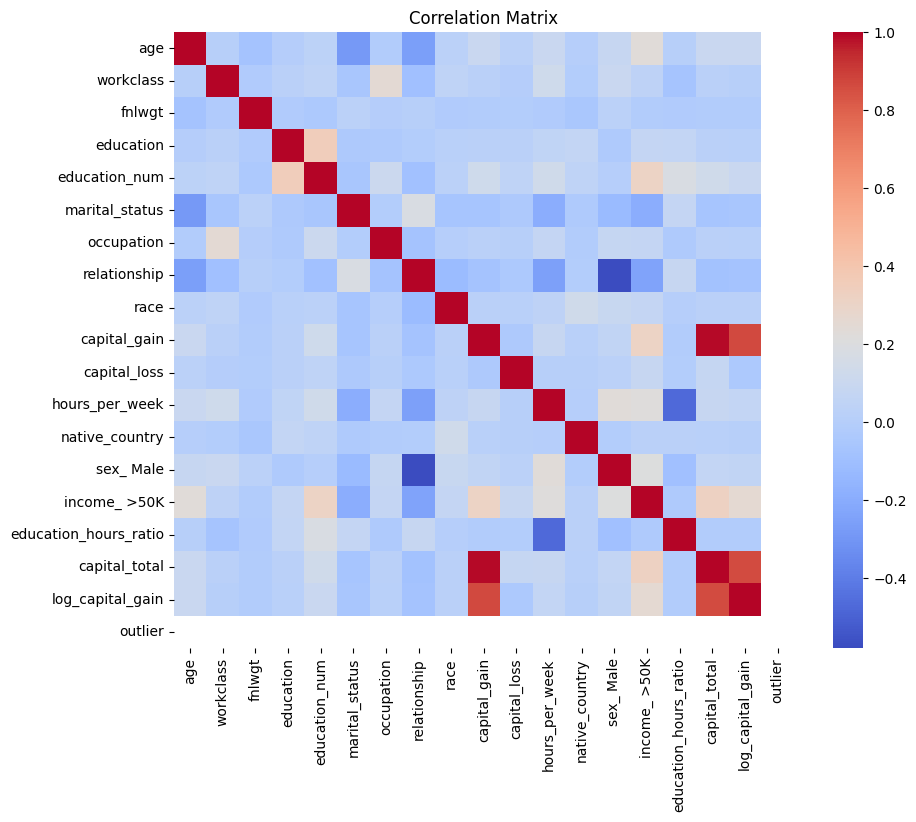

In [20]:
plt.figure(figsize=(10,8))
sns.heatmap(df_clean.corr(), cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

## Step 8: Predictive Power Score (PPS)

In [22]:
# pps_matrix = pps.matrix(df_clean) # Commented out as ppscore failed to install
# pps_matrix.sort_values(by="ppscore", ascending=False).head(10) # Commented out as ppscore failed to install


## Final Clean Dataset Ready for Modeling

In [21]:
print("Final dataset shape:", df_clean.shape)
df_clean.head()

Final dataset shape: (30933, 19)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,sex_ Male,income_ >50K,education_hours_ratio,capital_total,log_capital_gain,outlier
0,39,7,77516,9,13,4,1,1,4,2174,0,40,39,True,False,0.325,2174,7.684784,1
1,50,6,83311,9,13,2,4,0,4,0,0,13,39,True,False,1.000,0,0.000000,1
2,38,4,215646,11,9,0,6,1,4,0,0,40,39,True,False,0.225,0,0.000000,1
3,53,4,234721,1,7,2,6,0,2,0,0,40,39,True,False,0.175,0,0.000000,1
4,28,4,338409,9,13,2,10,5,2,0,0,40,5,False,False,0.325,0,0.000000,1
